In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, get_okabe_ito_palette, skipped_timeseries_formatting
import seaborn as sns
import matplotlib.patheffects as PathEffects
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as mcm
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 1: San Diego's genomic similarity to other locations in North America
We use the PhyloSor metric to measure the genomic similarity between San Diego and a number of other locations in North America, and determine that the county is regionally connected.

Load in the results from the PhyloSor analysis. These are the output of the `monterey` pipeline.

In [2]:
def load_results( loc, source, min_sequences = 0 ):
    """ Loads PhyloSor results from file.
    Parameters
    ----------
    loc : str
        Path to concatenated results files
    source : str
        Location to filter results to. Must be found in "siteA" column
    min_sequences : int
        Minimum number of genomes that both siteA and siteB must have for measurement to be included

    Returns
    -------
    pandas.DataFrame
        PhyloSor results
    """
    df = pd.read_csv( loc, parse_dates=["date"] )
    df = df.loc[df["siteA"]==source]
    df = df.loc[(df["countA"]>=min_sequences)&(df["countB"]>=min_sequences)]
    df["kind"] = df["kind"].fillna( "null" )
    df["kind"] = df["kind"] + df["num"].astype( str )
    df = df.drop( columns=["num"] )
    return df

def correct_names( entry ):
    return_value = entry.replace( "_", ", " )
    if return_value in ["British Columbia", "Ontario", "Alberta", "Québec", "Saskatchewan", "Manitoba", "Nova Scotia"]:
        return_value += ", CAN"
    elif return_value in ["Baja California", "Yucatán"]:
        return_value += ", MEX"
    return return_value

res = load_results( "../data/phylosor_results_subsampling.csv", source="San Diego_CA", min_sequences=30 )
res = res.loc[res["kind"]=="actual1"]
res["siteB"] = res["siteB"].apply( correct_names )
res = res.loc[res["siteB"].str.endswith( (" USA", " CAN", " MEX", " CA") )]
res.head()

blA     blB  blBoth       date         siteA  countA          siteB  \
0   210.0  1453.0    50.0 2020-03-01  San Diego_CA     184  New York, USA   
1   296.0  1527.0    28.0 2020-04-01  San Diego_CA     294  New York, USA   
2   555.0   534.0    31.0 2020-05-01  San Diego_CA     274  New York, USA   
3   696.0   213.0    23.0 2020-06-01  San Diego_CA     315  New York, USA   
4  1088.0   471.0    47.0 2020-07-01  San Diego_CA     468  New York, USA   

   countB     value  value_turn     kind  
0    2070  0.060132    0.238095  actual1  
1    1136  0.030719    0.094595  actual1  
2     272  0.056933    0.058052  actual1  
3      61  0.050605    0.107981  actual1  
4     147  0.060295    0.099788  actual1

PhyloSor similarity is calculated on a monthly basis. To calculate a summary across time, we min-max normalize the values for each month and plot the distribution of similarity for each location.

In [3]:
def calculate_order( results, normalize=True ):
    return_df = results.loc[results["kind"]=="actual1"]
    return_df = return_df.pivot( index="siteB", columns="date", values="value" )
    if normalize:
        return_df = (return_df-return_df.min())/(return_df.max()-return_df.min())
    return return_df

norm_values = calculate_order( res )
orders = norm_values.median( axis=1 ).sort_values( ascending=False ).index
norm_values = norm_values.reindex( index=orders )

To display the correlation between PhyloSor similarity and distance, we load in a shape file containing geographic information for all locations in North America.

In [4]:
states = gpd.read_file( "/Users/natem/Documents/Data/shapefiles/NA_states/bound_p.shp" )
states = states.loc[states["COUNTRY"].isin(["USA", "MEX", "CAN"])]
states = states.drop( columns=["OBJECTID", "BOUND_P_", "UIDENT", "Shape_Area", "Shape_Leng"])
states = states.dissolve( "NAME" ).reset_index()
states["NAME"] = states["NAME"].replace( {"British Columbia / Colombie-Britannique": "British Columbia", "Quebec / Québec" : "Québec", "Nova Scotia / Nouvelle-Écosse" : "Nova Scotia"} )
states["NAME"] = states["NAME"] + ", " + states["COUNTRY"]
states = states.loc[~states["NAME"].isin( ["California, USA","water/agua/d'eau, CAN"] )]
states["STATEABB"] = states["STATEABB"].fillna( "" ).apply( lambda x: x.split( "-" )[-1] )

ca = gpd.read_file( "/Users/natem/Documents/Data/shapefiles/USA_counties/gadm36_USA_2.shp" )
ca = ca.loc[ca["NAME_1"]=="California",["NAME_2", "geometry"]]
ca["COUNTRY"] = "USA"
ca.columns = ["NAME", "geometry", "COUNTRY"]
ca = ca.dissolve( "NAME").reset_index()
ca["NAME"] = ca["NAME"] + ", CA"

states = pd.concat( [states,ca], ignore_index=True )

# Haversine great circle distance
#states["longitude"] = states.centroid.x * (np.pi / 180)
#states["latitude"] = states.centroid.y * (np.pi / 180)
#states["distance"] = haversine_distances( states[["latitude","longitude"]] )[states.loc[states["NAME"]=="San Diego, CA"].index].T
states = states.to_crs( "EPSG:2163" )
states["geometry"] = states.simplify(1000)
states["distance"] = states.distance( states.loc[states["NAME"]=="San Diego, CA","geometry"].centroid.values[0] ) / 1000 # KM
states["norm_distance"] = states["distance"]
states["distance"] = np.log10( states["distance"] )

states

/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/constructive.py:881: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/Users/natem/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


NAME                                           geometry  \
0    Aguascalientes, MEX  POLYGON ((-198707.008 -2544337.499, -200108.56...   
1           Alabama, USA  MULTIPOLYGON (((1149723.362 -1556706.795, 1139...   
2            Alaska, USA  MULTIPOLYGON (((-4332957.499 3296537.514, -432...   
3           Alberta, CAN  POLYGON ((-558692.930 1700003.618, -644121.433...   
4           Arizona, USA  POLYGON ((-803220.067 -845640.068, -863633.459...   
..                   ...                                                ...   
152           Tulare, CA  POLYGON ((-1614470.731 -849845.881, -1748643.8...   
153         Tuolumne, CA  POLYGON ((-1681571.031 -606535.609, -1686263.2...   
154          Ventura, CA  MULTIPOLYGON (((-1804907.952 -1092281.957, -17...   
155             Yolo, CA  POLYGON ((-1912797.619 -421462.105, -1913904.6...   
156             Yuba, CA  POLYGON ((-1815449.095 -427965.827, -1817933.0...   

    COUNTRY STATEABB  distance  norm_distance  
0       MEX      AGU  3.266495    1847.120364  
1       USA       AL  3.420815    2635.205741  
2       USA       AK  3.426423    2669.457548  
3       CAN       AB  3.253048    1790.803854  
4       USA       AZ  2.273259     187.611508  
..      ...      ...       ...            ...  
152     USA      NaN  2.518504     329.992206  
153     USA      NaN  2.760637     576.284459  
154     USA      NaN  2.345810     221.722502  
155     USA      NaN  2.869755     740.892989  
156     USA      NaN  2.897870     790.441893  

[157 rows x 6 columns]

Now plot Figure 1C: each location in North America is colored based on their median min-max normalized PhyloSor similarity to San Diego for the period March 2020-May 2022. The five closest locations are also manually labeled.

/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/natem/mambaforge/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/natem/mambaforge/lib/python3.10/site-packages/shapely

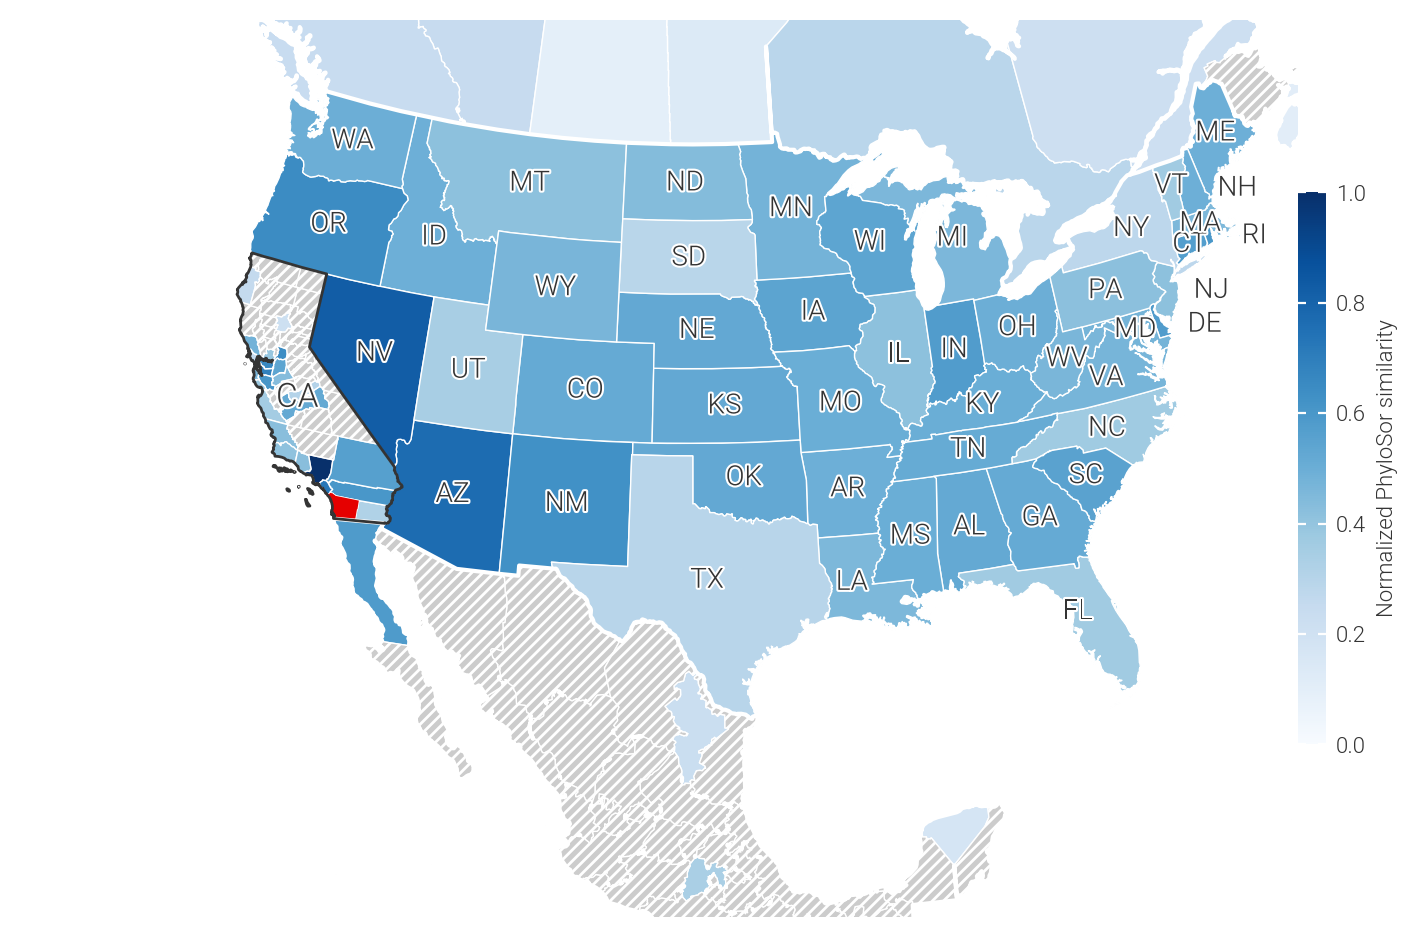

In [5]:
waves = {
    "median": norm_values.columns,
    "first_wave" : ["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01"],
    "first_trough" : ["2020-09-01", "2020-10-01"],
    "second_wave" : ["2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"],
    "second_trough" : ["2021-03-01", "2021-04-01", "2021-05-01", "2021-06-01"],
    "third_wave" : ["2021-07-01", "2021-08-01", "2021-09-01"],
    "third_trough" : ["2021-10-01", "2021-11-01"],
    "fourth_wave" : ["2021-12-01", "2022-01-01", "2022-02-01"],
    "fourth_trough" : ["2022-03-01", "2022-04-01"],
    "fifth_wave" : ["2022-05-01", "2022-06-01", "2022-07-01", "2022-08-01", "2022-09-01"],
    #"fifth_trough" : ["2022-10-01", "2022-11-01"]
}

median_list = list()
for title, wave in waves.items():
    medians = norm_values[wave].median( axis=1 )
    medians.name = title
    median_list.append( medians )

median_df = pd.concat( median_list, axis=1, ignore_index=False )

plot_states = states.merge( median_df, left_on="NAME", right_index=True, how="outer" )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_states.plot( column="median", edgecolor="w", linewidth=0.5, ax=ax, cmap="Blues",
              vmin=0, vmax=1,
              missing_kwds={
                 "color": "#cccccc",
                 "hatch": "//////",
                 "label": "Missing values",
             } )

plot_states.loc[plot_states["COUNTRY"]=="CAN"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_states.loc[plot_states["COUNTRY"]=="MEX"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_states.loc[plot_states["NAME"]=="San Diego, CA"].plot( color="#E50000", ax=ax )
plot_ca = plot_states[plot_states["NAME"].str.endswith( ", CA" )]
plot_ca["geometry"] = plot_ca["geometry"].buffer( 500 )
plot_ca.dissolve().boundary.plot( linewidth=1, edgecolor=COLOR, ax=ax )

for _, entry in plot_states.loc[(plot_states["COUNTRY"]=="USA")&(~plot_states["NAME"].str.endswith( "CA" ) )].iterrows():
    offset = 0
    if entry["STATEABB"] == "LA":
        offset = -55000
    elif entry["STATEABB"] in ["DE", "NJ", "RI", "NH"]:
        offset = 200000
    ax.annotate(entry["STATEABB"], xy=( entry["geometry"].centroid.x+offset, entry["geometry"].centroid.y ), ha="center", va="center", fontsize=10, color=COLOR, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="white")])

ax.annotate( "CA", xy=(plot_ca.iloc[0]["geometry"].centroid.x+1.4e5,plot_ca.iloc[0]["geometry"].centroid.y-1.2e5), ha="center", va="center", fontsize=12, color=COLOR, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="white")])

cbar = fig.colorbar( mcm.ScalarMappable( cmap="Blues", norm=Normalize(vmin=0, vmax=1 ) ), shrink=0.5, pad=0 )
cbar.outline.set_visible( False )
cbar.set_label( "Normalized PhyloSor similarity", fontsize=8 )
cbar.ax.tick_params( labelsize=8, size=3, left=True, right=True, color="w", direction="in", which="both" )

ax.set_xlim( (-3e6, 2.7e6) )
ax.set_ylim( (-3e6, 1e6) )
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.set_yticks([])
ax.set_xticks([])
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-map-us.pdf" )
plt.show()

We additionally plot an inset of California, to clarify the local geography. 

/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/natem/mambaforge/lib/python3.10/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/natem/mambaforge/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/natem/mambaforge/lib/python3.10/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/natem/mambaforge/lib/python3.10/s

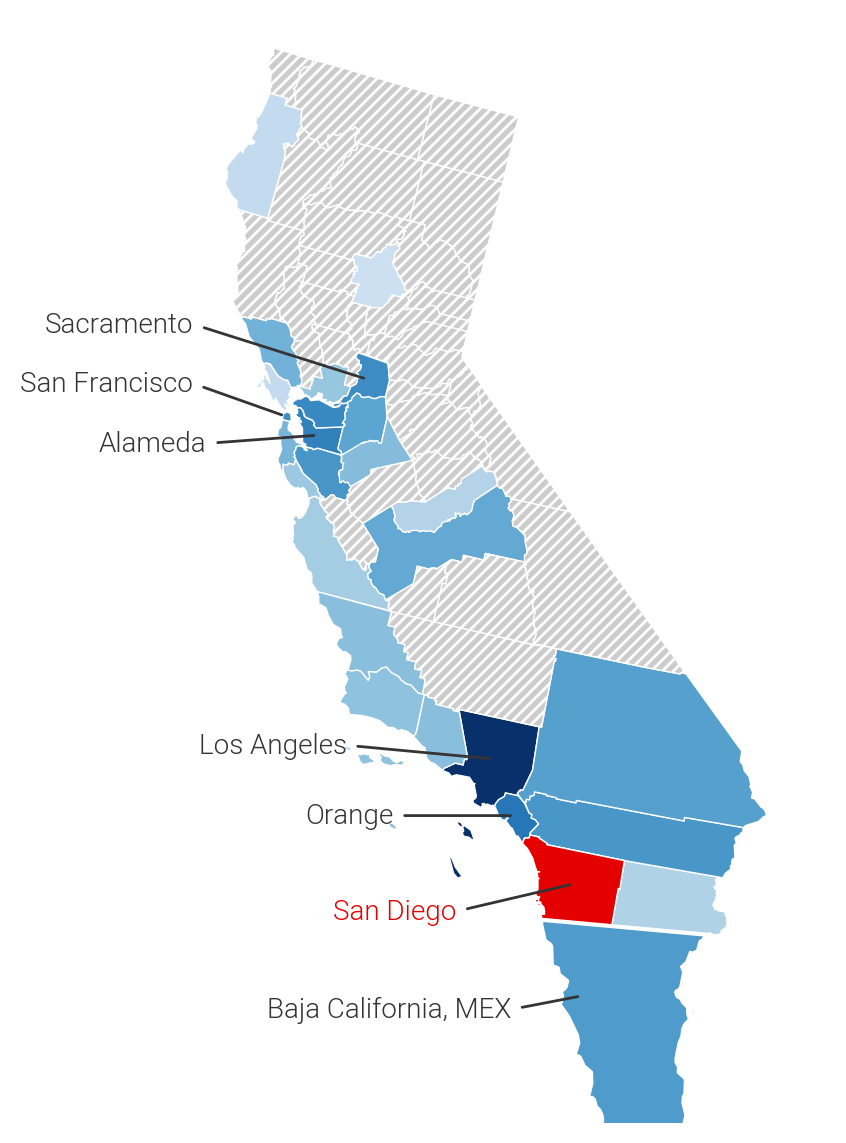

In [6]:
fig, ax = plt.subplots( dpi=200, figsize=(6,6) )
cali = plot_states.loc[plot_states["NAME"].str.endswith( ", CA" )]
cali.plot( column="median", edgecolor="w", linewidth=0.5, ax=ax, cmap="Blues",
              vmin=0, vmax=1,
              missing_kwds={
                 "color": "#cccccc",
                 "hatch": "//////",
                 "label": "Missing values",
             } )
plot_states.loc[plot_states["NAME"]=="Baja California, MEX"].plot( column="median", edgecolor="w", linewidth=0.5, ax=ax, cmap="Blues",
              vmin=0, vmax=1 )
plot_states.loc[plot_states["COUNTRY"]=="MEX"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_states.loc[plot_states["NAME"]=="San Diego, CA"].plot( color="#E50000", edgecolor="w", linewidth=0.5, ax=ax )

arrowprops = dict(arrowstyle="-", relpos=(1,0.5), color=COLOR )
centroid = plot_states.loc[plot_states["NAME"]=="Alameda, CA", "geometry"].centroid
ax.annotate( "Alameda", (centroid.x, centroid.y), (-60,-3), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_states.loc[plot_states["NAME"]=="Sacramento, CA", "geometry"].centroid
ax.annotate( "Sacramento", (centroid.x, centroid.y), (-90,20), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_states.loc[plot_states["NAME"]=="Los Angeles, CA", "geometry"].centroid
ax.annotate( "Los Angeles", (centroid.x, centroid.y), (-80,5), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_states.loc[plot_states["NAME"]=="Orange, CA", "geometry"].centroid
ax.annotate( "Orange", (centroid.x, centroid.y), (-60,0), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_states.loc[plot_states["NAME"]=="San Francisco, CA", "geometry"].centroid
ax.annotate( "San Francisco", (centroid.x, centroid.y), (-65,12), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_states.loc[plot_states["NAME"]=="San Diego, CA", "geometry"].centroid
ax.annotate( "San Diego", (centroid.x, centroid.y), (-65,-10), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops, color="#E50000" )
centroid = plot_states.loc[plot_states["NAME"]=="Baja California, MEX", "geometry"].centroid
ax.annotate( "Baja California, MEX", (centroid.x-1e5, centroid.y+1.5e5), (-70,-5), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops  )


ax.set_xlim(-2070763.7202096367, -1213998.9315272244)
ax.set_ylim( -1.5e6, 0 )
ax.set_yticks([])
ax.set_xticks([])
[ax.spines[j].set_visible(False) for j in ax.spines]
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-map-ca.pdf", transparent=True )
plt.show()

We next plot Figures 1D-E, which are temporal trends in the PhyloSor similarity to San Diego for the 5 locations with the highest and lowest median similarity to San Diego.

/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_20079/3452080158.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = mcm.get_cmap( "tab10" )
/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


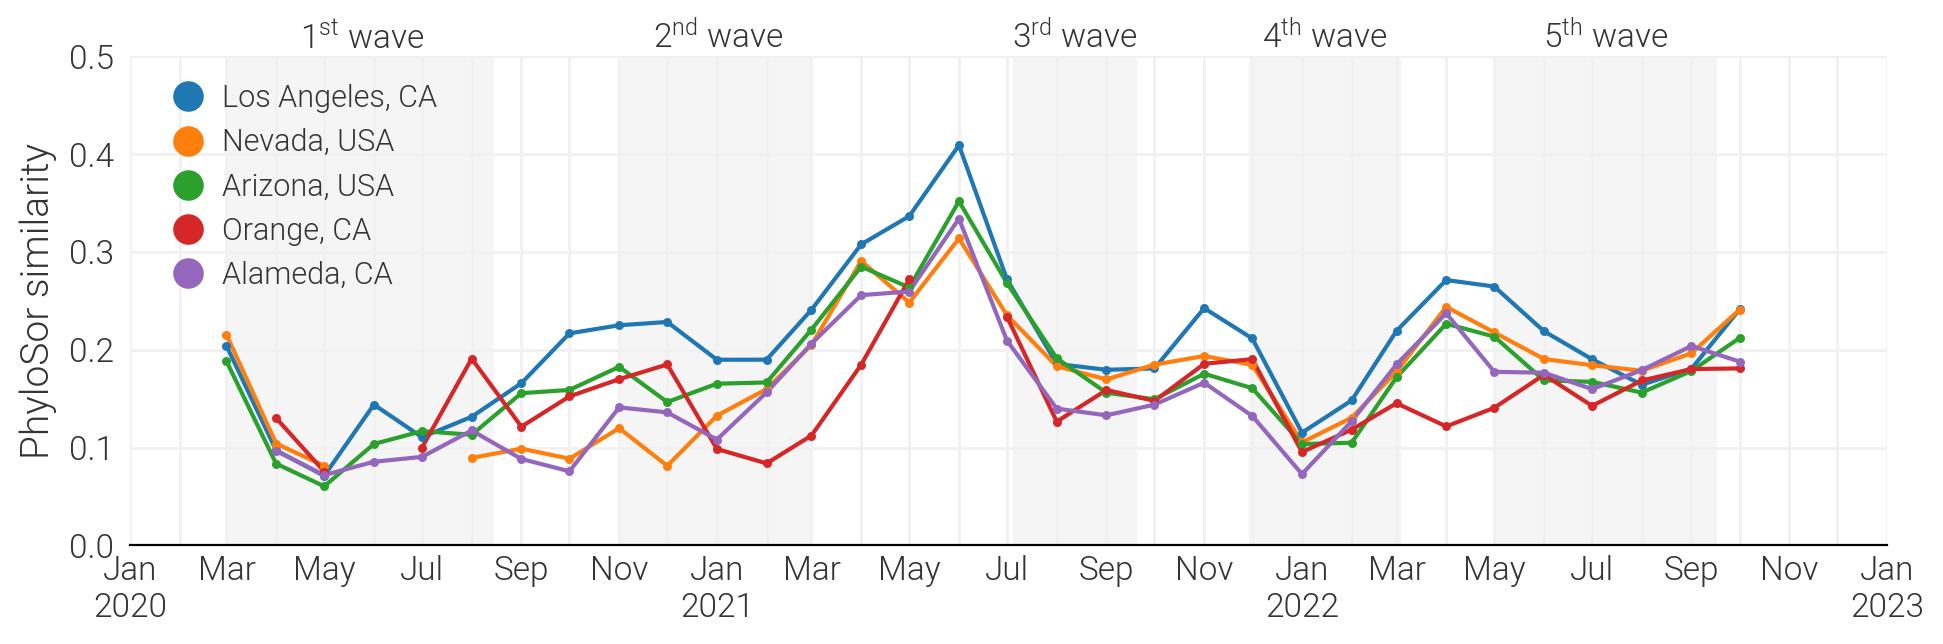

In [7]:
paired = get_okabe_ito_palette()
ps_df = calculate_order( res, normalize=False )
ps_df = ps_df.reindex( index=orders )
plot_df = ps_df.iloc[:5].melt( ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(10,3.5) )
count = 0
legend = []
tab10 = mcm.get_cmap( "tab10" )
for count, name in enumerate( orders[:5] ):
    ax.plot( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=tab10(count), zorder=100 )
    ax.scatter( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=tab10(count), s=5, zorder=102 )
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=tab10(count), label=name, markersize=10 ) )
    count += 1

ax.legend( handles=legend, loc="upper left", handletextpad=0.1, frameon=False, fontsize=11 )
basic_formatting( ax, which="both", xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2023-01-01") ), ylims=(0, 0.5), ysize=12, xsize=12 )
ax.set_ylabel( "PhyloSor similarity", fontsize=14)

#ax.axvspan( "2020-03-01", waves["first_wave"][-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
#ax.annotate( "$\mathregular{1^{st}}$ wave", (pd.to_datetime( waves["first_wave"][0] ), 0.5), (55,3), textcoords="offset points", ha="center", fontsize=12 )
#ax.axvspan( waves["second_wave"][0], waves["second_wave"][-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
#ax.annotate( "$\mathregular{2^{nd}}$ wave", (pd.to_datetime( waves["second_wave"][0] ), 0.5), (35,3), textcoords="offset points", ha="center", fontsize=12   )
#ax.axvspan( waves["third_wave"][0], waves["third_wave"][-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
#ax.annotate("$\mathregular{3^{rd}}$ wave", (pd.to_datetime( waves["third_wave"][0] ), 0.5), (23,3), textcoords="offset points", ha="center", fontsize=12 )
#ax.axvspan( waves["fourth_wave"][0], waves["fourth_wave"][-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
#ax.annotate( "$\mathregular{4^{th}}$ wave", (pd.to_datetime( waves["fourth_wave"][0] ), 0.5), (23,3), textcoords="offset points", ha="center", fontsize=12 )

ax.axvspan( "2020-03-01", "2020-08-15", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{1^{st}}$ wave", (pd.to_datetime( "2020-03-01" ), 0.5), (49,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2020-11-02", "2021-03-02", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{2^{nd}}$ wave", (pd.to_datetime( "2020-11-02" ), 0.5), (35,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-07-05", "2021-09-20", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate("$\mathregular{3^{rd}}$ wave", ( pd.to_datetime("2021-07-05" ), 0.5), (22,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-11-29", "2022-03-04", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{4^{th}}$ wave", (pd.to_datetime( "2021-11-29" ), 0.5), (27,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2022-05-01", "2022-09-17", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{5^{th}}$ wave", (pd.to_datetime( "2022-07-01" ), 0.5), (5,3), textcoords="offset points", ha="center", fontsize=12 )

skipped_timeseries_formatting( ax )
ax.tick_params( axis="y", pad=2.5 )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-top-locations.pdf" )
plt.show()

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


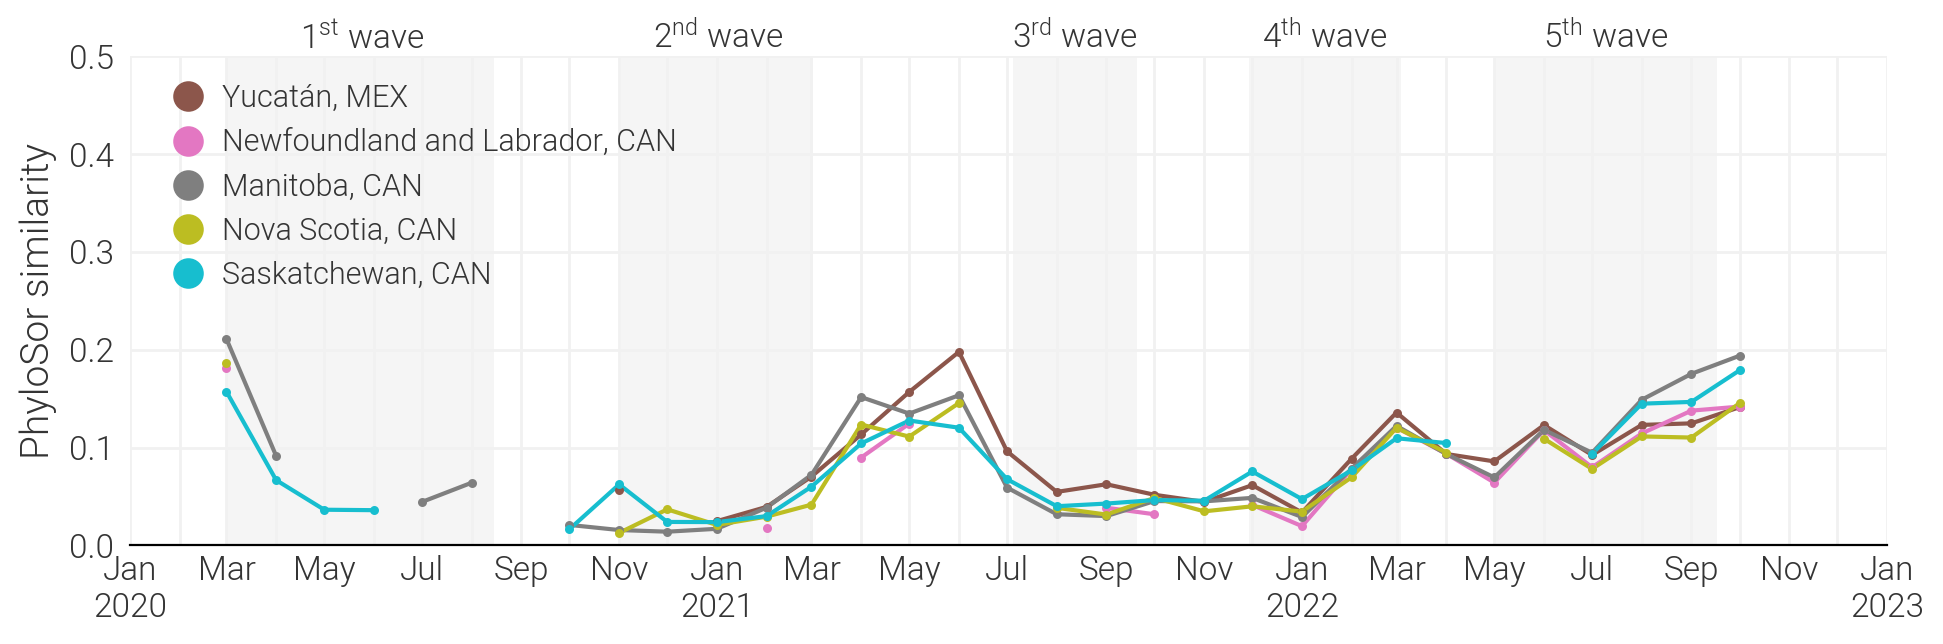

In [8]:
plot_df = ps_df.iloc[-5:].melt( ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(10,3.5) )
count = 0
legend = []
for count, name in enumerate( orders[-5:] ):
    ax.plot( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=tab10(count+5), zorder=100 )
    ax.scatter( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=tab10(count+5), s=5, zorder=102 )
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=tab10(count+5), label=name, markersize=10 ) )
    count += 1

ax.legend( handles=legend, loc="upper left", handletextpad=0.1, frameon=False, fontsize=11 )
basic_formatting( ax, which="both", xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2023-01-01") ), ylims=(0, 0.5), ysize=12, xsize=12 )
ax.set_ylabel( "PhyloSor similarity", fontsize=14)

ax.axvspan( "2020-03-01", "2020-08-15", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{1^{st}}$ wave", (pd.to_datetime( "2020-03-01" ), 0.5), (49,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2020-11-02", "2021-03-02", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{2^{nd}}$ wave", (pd.to_datetime( "2020-11-02" ), 0.5), (35,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-07-05", "2021-09-20", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate("$\mathregular{3^{rd}}$ wave", ( pd.to_datetime("2021-07-05" ), 0.5), (22,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-11-29", "2022-03-04", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{4^{th}}$ wave", (pd.to_datetime( "2021-11-29" ), 0.5), (27,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2022-05-01", "2022-09-17", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{5^{th}}$ wave", (pd.to_datetime( "2022-07-01" ), 0.5), (5,3), textcoords="offset points", ha="center", fontsize=12 )

skipped_timeseries_formatting( ax )
ax.tick_params( axis="y", pad=2.5 )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-bottom-locations.pdf" )
plt.show()

We test whether PhyloSor similarity to San Diego is correlated with centroid-centroid distance to San Diego. Correlation coefficient, specifically Pearson r-squared, is estimated by bootstraping locations 1000 times.

Value = 0.10; 95% CI, 0.01149 to 0.24211 (p = 0.003)


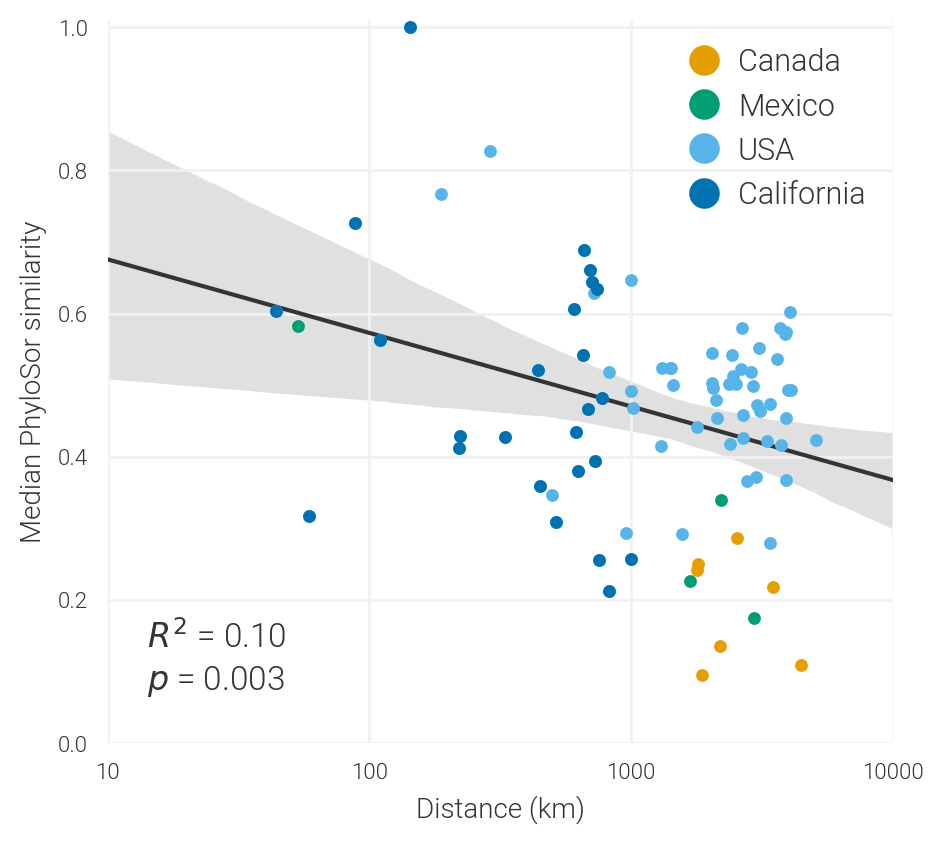

In [9]:
def get_coefficient( data, independent, dependent, bootstraps=1000, return_data=False ):

    data_clean = data.dropna( subset=[independent, dependent])

    results = []
    for i in range(bootstraps):
        boot = data_clean.sample( frac=1, replace=True )
        test_x = boot[independent].to_list()
        test_y = boot[dependent].to_list()
        results.append( pearsonr( test_x, test_y )[0]**2 )

    test_x = data_clean[dependent].to_list()
    test_y = data_clean[independent].to_list()
    print( f"Value = {np.quantile( results, 0.5 ):.2f}; 95% CI, {np.quantile( results, 0.025 ):.5f} to {np.quantile( results, 0.975 ):.5f} (p = {pearsonr( test_x, test_y )[1]:.3f})" )
    if return_data:
        return results
    return np.quantile( results, 0.5 ), pearsonr( test_x, test_y )[1]

fig, ax = plt.subplots( dpi=200, figsize=(5,4.5) )

for loc, color in [ ("USA", "#56B4E9"), ("CAN", "#E69F00"), ("MEX", "#009E73")]:
    temp = plot_states.loc[plot_states["COUNTRY"]==loc]
    ax.scatter( x=temp["distance"], y=temp["median"], c=color, s=13, zorder=10 )
ax.scatter( x="distance", y="median", data=plot_states.loc[plot_states["NAME"].str.endswith( "CA" )], c="#0072B2", s=13, zorder=11)

ax.set_ylim( 0, 1.01 )
ax.set_xlim( 1,4 )
ax.set_xticks( [1, 2, 3, 4] )
ax.set_xticklabels( [10, 100, 1000, 10000] )

sns.regplot( x="distance", y="median", data=plot_states, color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax, truncate=False )

ax.set_xlabel( "Distance (km)", fontsize=10 )
ax.set_ylabel( "Median PhyloSor similarity", fontsize=10 )

coeff = get_coefficient( plot_states.loc[~plot_states["median"].isna()], "distance" ,"median" )
ax.text( 0.05, 0.17, f"$R^2$ = {coeff[0]:.2f}", transform=ax.transAxes, fontsize=12, ha="left", va="top" )
ax.text( 0.05, 0.11, f"$p$ = {coeff[1]:.3f}", transform=ax.transAxes, fontsize=12, ha="left", va="top" )
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1)
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=8 )
ax.tick_params( axis="y", left=False, which="both", labelsize=8 )
ax.set_facecolor( "w" )

legend = [
    Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Canada", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Mexico", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#56B4E9", label="USA", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#0072B2", label="California", markersize=10 )
]

ax.legend( handles=legend, loc="upper right", handletextpad=0.1, frameon=False, fontsize=11 )

plt.tight_layout()
fig.savefig( "../analyses/plots/figure1_phylosor-distance.pdf" )
fig.savefig( "../paper/figures/suppfigure5.png" )
fig.savefig( "../paper/figures/suppfigure5.pdf" )
plt.show()

We test the correlation just when we consider counties in California.

In [16]:
test = plot_states.loc[plot_states["NAME"].str.endswith(", CA")]
test = test.dropna( subset="median")
cal_res = get_coefficient( test, "median", "distance" )

Value = 0.09; 95% CI, 0.00034 to 0.37119 (p = 0.156)


We test the correlation when we only consider US states.

In [17]:
test = plot_states.loc[plot_states["NAME"].str.endswith(", USA")]
test = test.dropna( subset="median")
usa_res = get_coefficient( test, "median", "distance" )

Value = 0.14; 95% CI, 0.00055 to 0.48095 (p = 0.006)


We test the correlation between PhyloSor similarity and geographic distance for each wave and trough of the pandemic. Refer to `figureS4_san-diego-waves.ipynb` for wave definitions.

In [9]:
result_dict = dict()
pvalues = dict()
for wave in waves.keys():
    print( wave )
    wave_results = get_coefficient( plot_states.loc[~plot_states[wave].isna()], "distance", wave, return_data=True)
    pvalues[wave] = get_coefficient( plot_states.loc[~plot_states[wave].isna()], "distance", wave )[1]
    result_dict[wave] = wave_results

median
Value = 0.10; 95% CI, 0.00916 to 0.24622 (p = 0.003)
Value = 0.10; 95% CI, 0.00944 to 0.23528 (p = 0.003)
first_wave
Value = 0.24; 95% CI, 0.04737 to 0.51399 (p = 0.000)
Value = 0.23; 95% CI, 0.04407 to 0.51094 (p = 0.000)
first_trough
Value = 0.53; 95% CI, 0.28221 to 0.69358 (p = 0.000)
Value = 0.52; 95% CI, 0.28188 to 0.68585 (p = 0.000)
second_wave
Value = 0.42; 95% CI, 0.25184 to 0.58576 (p = 0.000)
Value = 0.42; 95% CI, 0.24212 to 0.58200 (p = 0.000)
second_trough
Value = 0.05; 95% CI, 0.00115 to 0.16935 (p = 0.039)
Value = 0.05; 95% CI, 0.00029 to 0.17599 (p = 0.039)
third_wave
Value = 0.01; 95% CI, 0.00001 to 0.08874 (p = 0.968)
Value = 0.01; 95% CI, 0.00001 to 0.08091 (p = 0.968)
third_trough
Value = 0.12; 95% CI, 0.00765 to 0.29691 (p = 0.001)
Value = 0.12; 95% CI, 0.00772 to 0.29361 (p = 0.001)
fourth_wave
Value = 0.01; 95% CI, 0.00003 to 0.08262 (p = 0.639)
Value = 0.01; 95% CI, 0.00003 to 0.10152 (p = 0.639)
fourth_trough
Value = 0.06; 95% CI, 0.00276 to 0.19278 (p =

We plot Figure 1F, estimated Spearman Rho-squared values for the correlation between PhyloSor similarity and centroid-centroid distance for each wave and trough of the pandemic in San Diego.

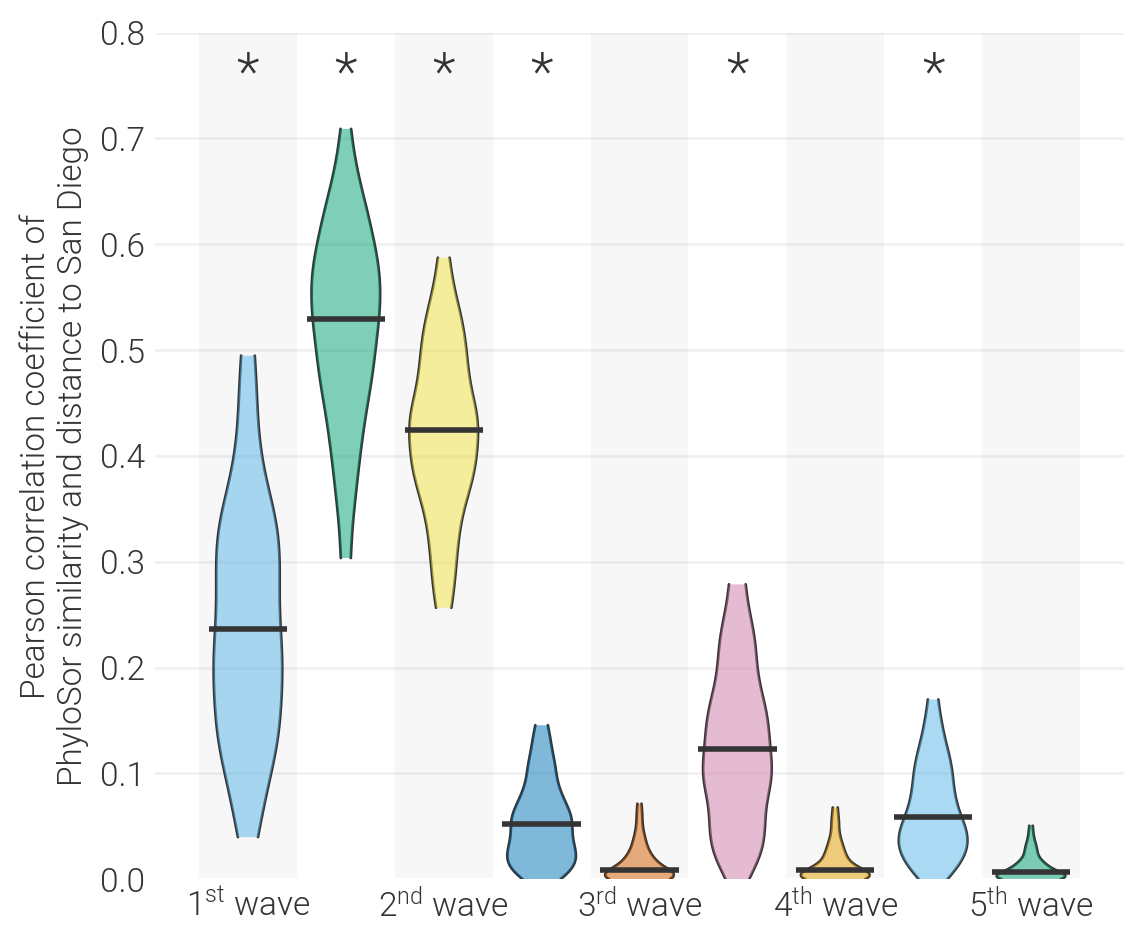

In [13]:
distance_corr = pd.DataFrame( result_dict )
fig, ax = plt.subplots( dpi=200, figsize=(6,5) )

colors = paired
for i, query in enumerate( distance_corr.columns ):
    if query != "median":
        data = distance_corr[query].to_numpy().ravel()
        data = data[~np.isnan(data)]
        data_median = np.median( data )

        hpdHi, hpdLo = hpd( data, 0.95 )
        x_grid = np.linspace( hpdLo, hpdHi, 101 )

        kde = gaussian_kde( data )
        y_grid = kde.evaluate( x_grid )
        y_grid = y_grid / y_grid.max() * 0.35

        ax.plot([i+y for y in y_grid],x_grid,color=COLOR,lw=1,zorder=100)
        ax.plot([i-y for y in y_grid],x_grid,color=COLOR,lw=1,zorder=100)

        ax.fill_betweenx(x_grid,[i-y for y in y_grid],[i+y for y in y_grid],facecolor=colors[i%len(colors)],edgecolor='none',alpha=0.5,zorder=100)
        ax.hlines( y=data_median, xmin=i-0.4, xmax=i+0.4, color=COLOR, linewidth=2, zorder=110 )
        if pvalues[query] < 0.05:
            ax.text( x=i, y=0.8*0.95, s="*", ha="center", va="center", fontsize="large")

ax.set_xticks( range(1, len( distance_corr.columns ), 2 ) )
ax.set_xticklabels( ["$\mathregular{1^{st}}$ wave", "$\mathregular{2^{nd}}$ wave", "$\mathregular{3^{rd}}$ wave", "$\mathregular{4^{th}}$ wave", "$\mathregular{5^{th}}$ wave"] )

ax.axvspan( 0.5,1.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
ax.axvspan( 2.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
ax.axvspan( 4.5,5.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
ax.axvspan( 6.5,7.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )
ax.axvspan( 8.5,9.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

basic_formatting( ax, ylabel="Pearson correlation coefficient of\nPhyloSor similarity and distance to San Diego", ylims=(0, 0.8) )
ax.tick_params( axis="x", which="both", rotation=0 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-correlation-per-wave.pdf" )
plt.show()

# Diagnostic plots
We found that PhyloSor is influenced by sampling, and is particularly inaccurate when sampling is low. We thus filtered comparisons in which either location had less than 30 sequences. To determine how we arrived at that threshold, the following graphs were consulted.

We calculate median phylosor values and rank of each locations given a minimum number of sequence requirement between 1-100.

In [15]:
medians = []
ranks = []
counts = []
variance = []

test_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for count in test_values:
    res = load_results( loc="../data/phylosor_results.csv", source="San Diego_CA", min_sequences=count )
    orders = calculate_order( res )
    median = orders.median( axis=1 )
    median.name = count
    rank = median.rank( ascending=False )
    rank.name = count
    nonna = orders.count( axis=1 )
    nonna.name = count

    var = orders.std( axis=1 )
    var.name = count

    medians.append( median )
    ranks.append( rank )
    counts.append( nonna )
    variance.append( var )

medians = pd.concat( medians, axis=1, ignore_index=False )
plot_order = medians[1].sort_values().index
medians_corr = medians.corr()
medians = medians.melt( var_name="min_sequences", value_name="median_value", ignore_index=False ).reset_index()
ranks = pd.concat( ranks, axis=1, ignore_index=False )
ranks = ranks.melt( var_name="min_sequences", value_name="rank", ignore_index=False ).reset_index()
counts = pd.concat( counts, axis=1, ignore_index=False )
counts = counts.melt( var_name="min_sequences", value_name="nonnull_months", ignore_index=False ).reset_index()
variance = pd.concat( variance, axis=1, ignore_index=False )

plot_df = medians.merge( counts ).merge( ranks )
plot_df.head()

siteB  min_sequences  median_value  nonnull_months  rank
0  Alabama_USA              1      0.352252              27  61.0
1   Alameda_CA              1      0.691383              28   4.0
2   Alaska_USA              1      0.382879              27  48.0
3  Alberta_CAN              1      0.225057              26  71.0
4  Arizona_USA              1      0.739161              28   2.0

The following plot shows how each locations median rank changes given a minimum sequence requirement. Each point is labeled with the number of months for that location that have passed the requirement.

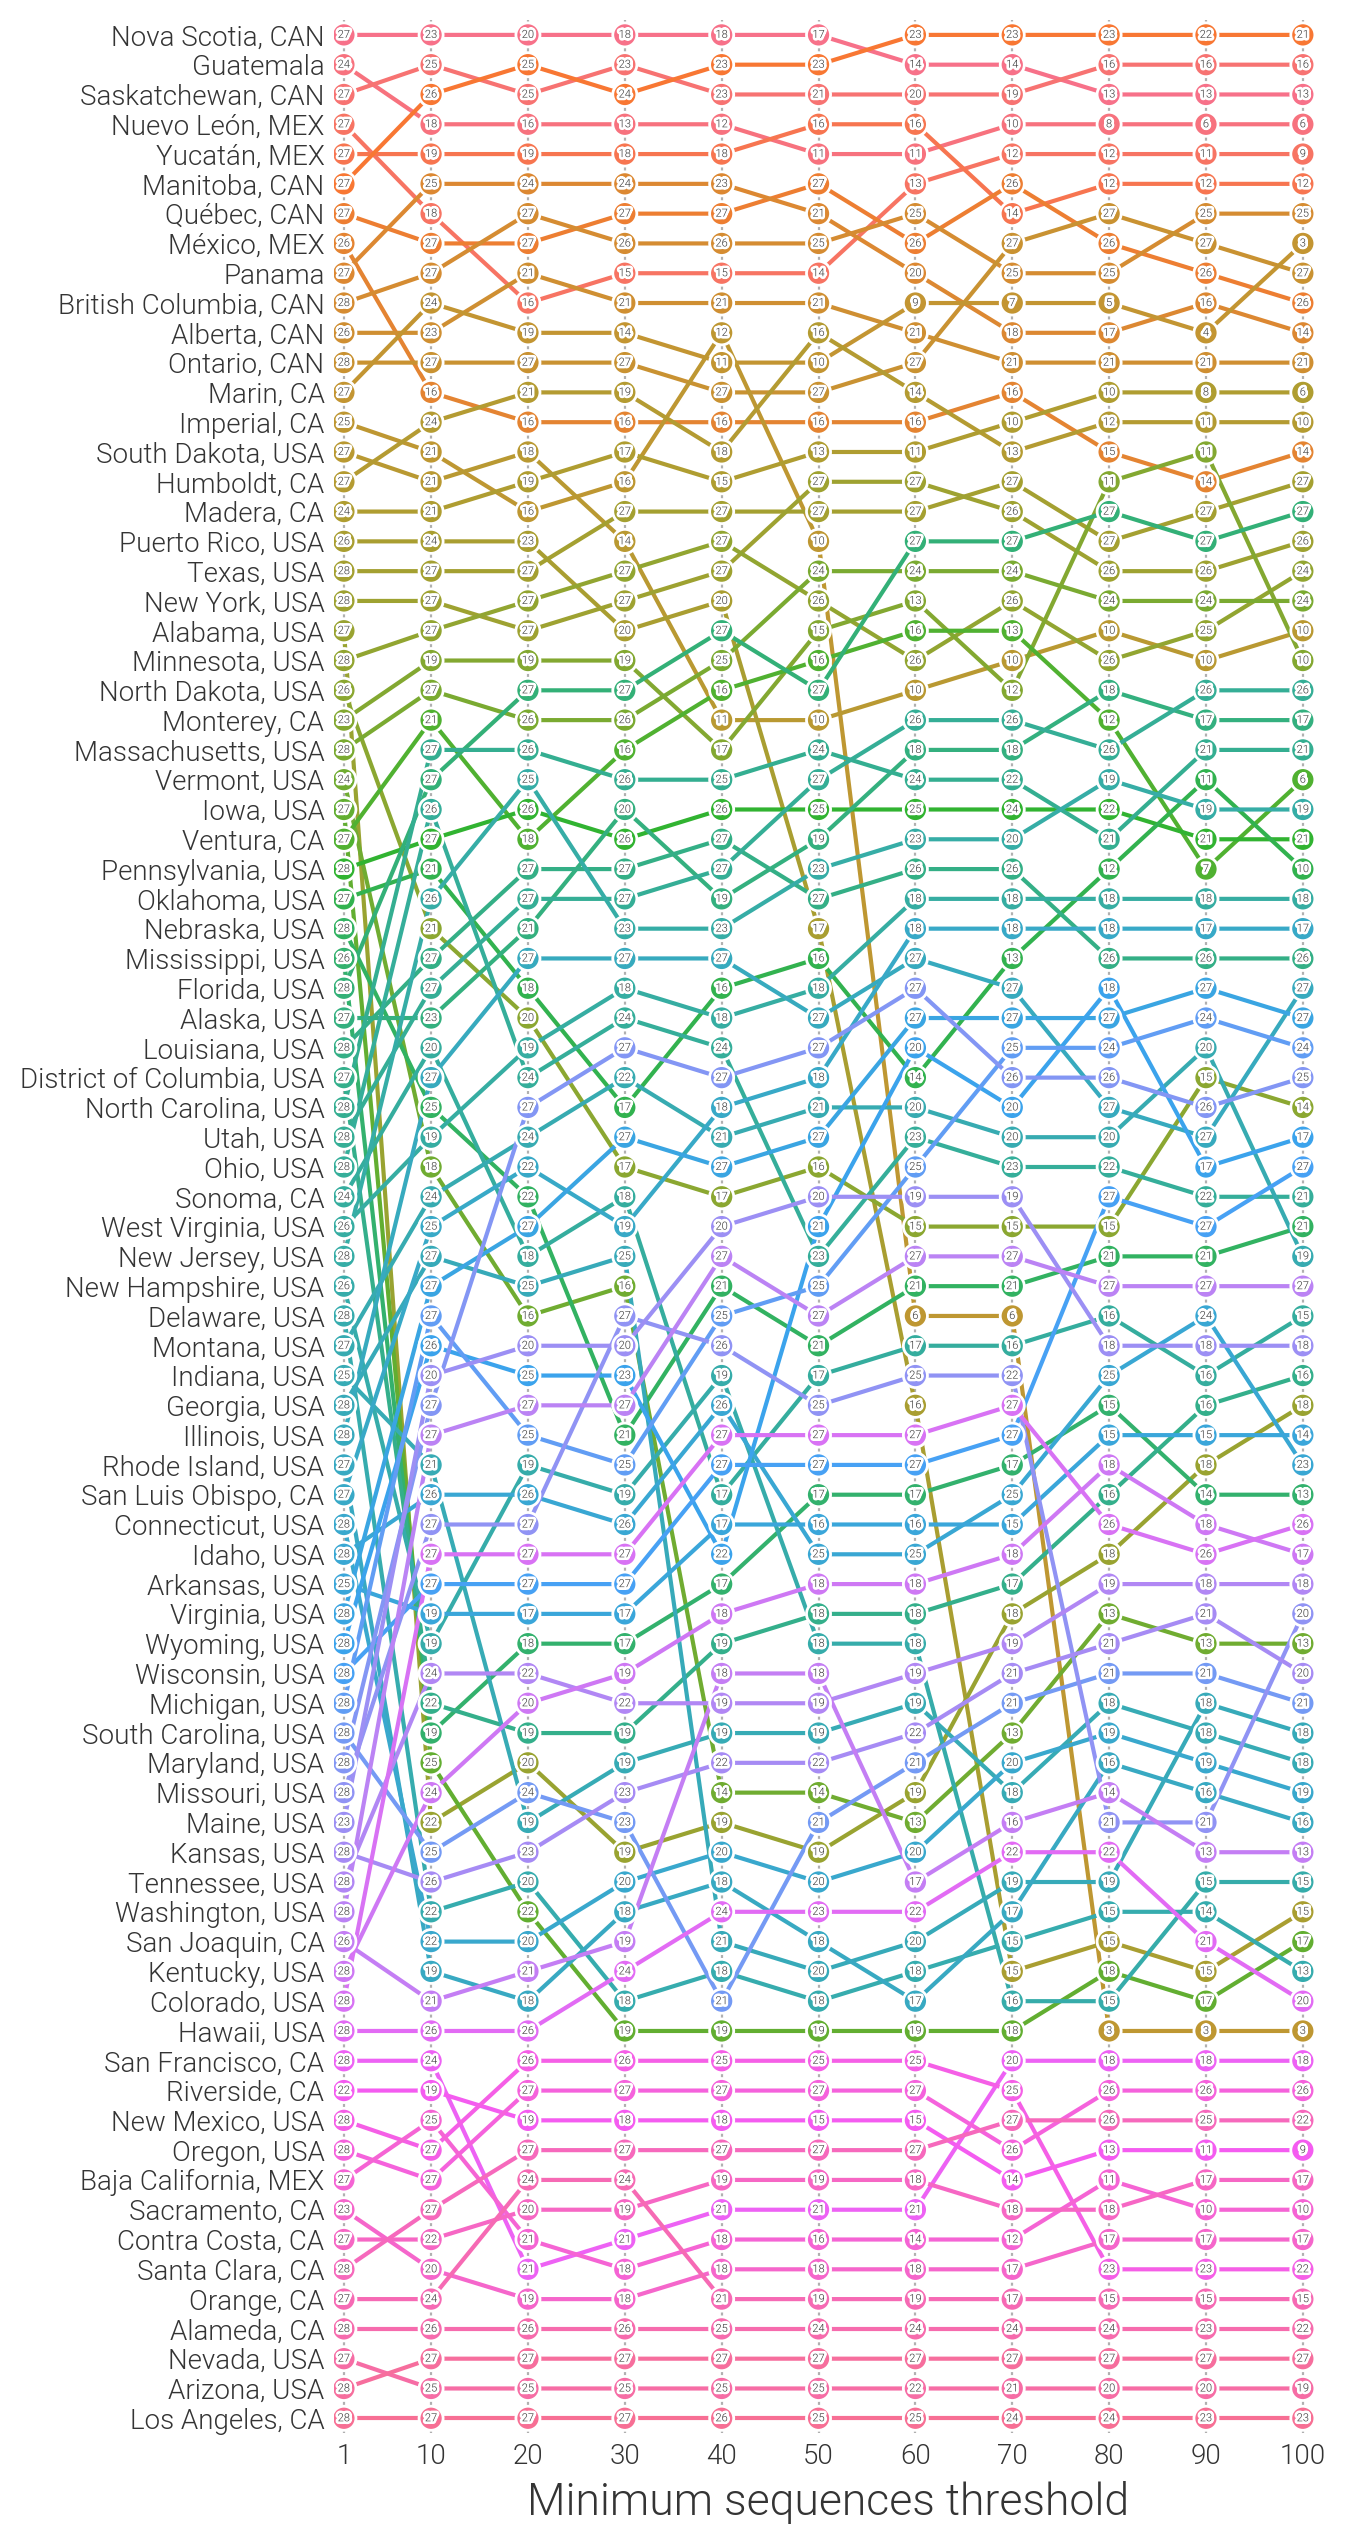

In [16]:
fig, ax = plt.subplots( dpi=200, figsize=(7,13) )
sns.lineplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100, ax=ax )
sns.scatterplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, s=75, hue_order=plot_order, zorder=101, ax=ax, linewidth=1)

for _, i in plot_df.iterrows():
    txt = ax.text( x=i["min_sequences"], y=i["rank"], s=f'{i["nonnull_months"]:.0f}', zorder=105, ha="center", va="center", fontsize=4 )
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

ax.set_xticks( test_values )
ax.set_xlim( 0, test_values[-1]+2 )
ax.set_xlabel( "Minimum sequences threshold" )
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=10, pad=0 )
ax.set_yticks( range(1, len( plot_order ) + 1 ) )
ax.set_yticklabels( reversed( plot_order.map( lambda x: x.replace( "_", ", " ) ) ) )
ax.set_ylabel( "" )
ax.set_ylim( 0.5, len( plot_order ) + 0.5 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10, pad=0 )
[ax.spines[j].set_visible( False ) for j in ax.spines]
ax.legend().remove()
ax.grid( axis="x", zorder=1 )
plt.tight_layout()
plt.savefig( "figure_phylosor_ranking.pdf")
plt.show()

We next plot how median normalized PhyloSor value changes given a specific minimum sequence requirement.

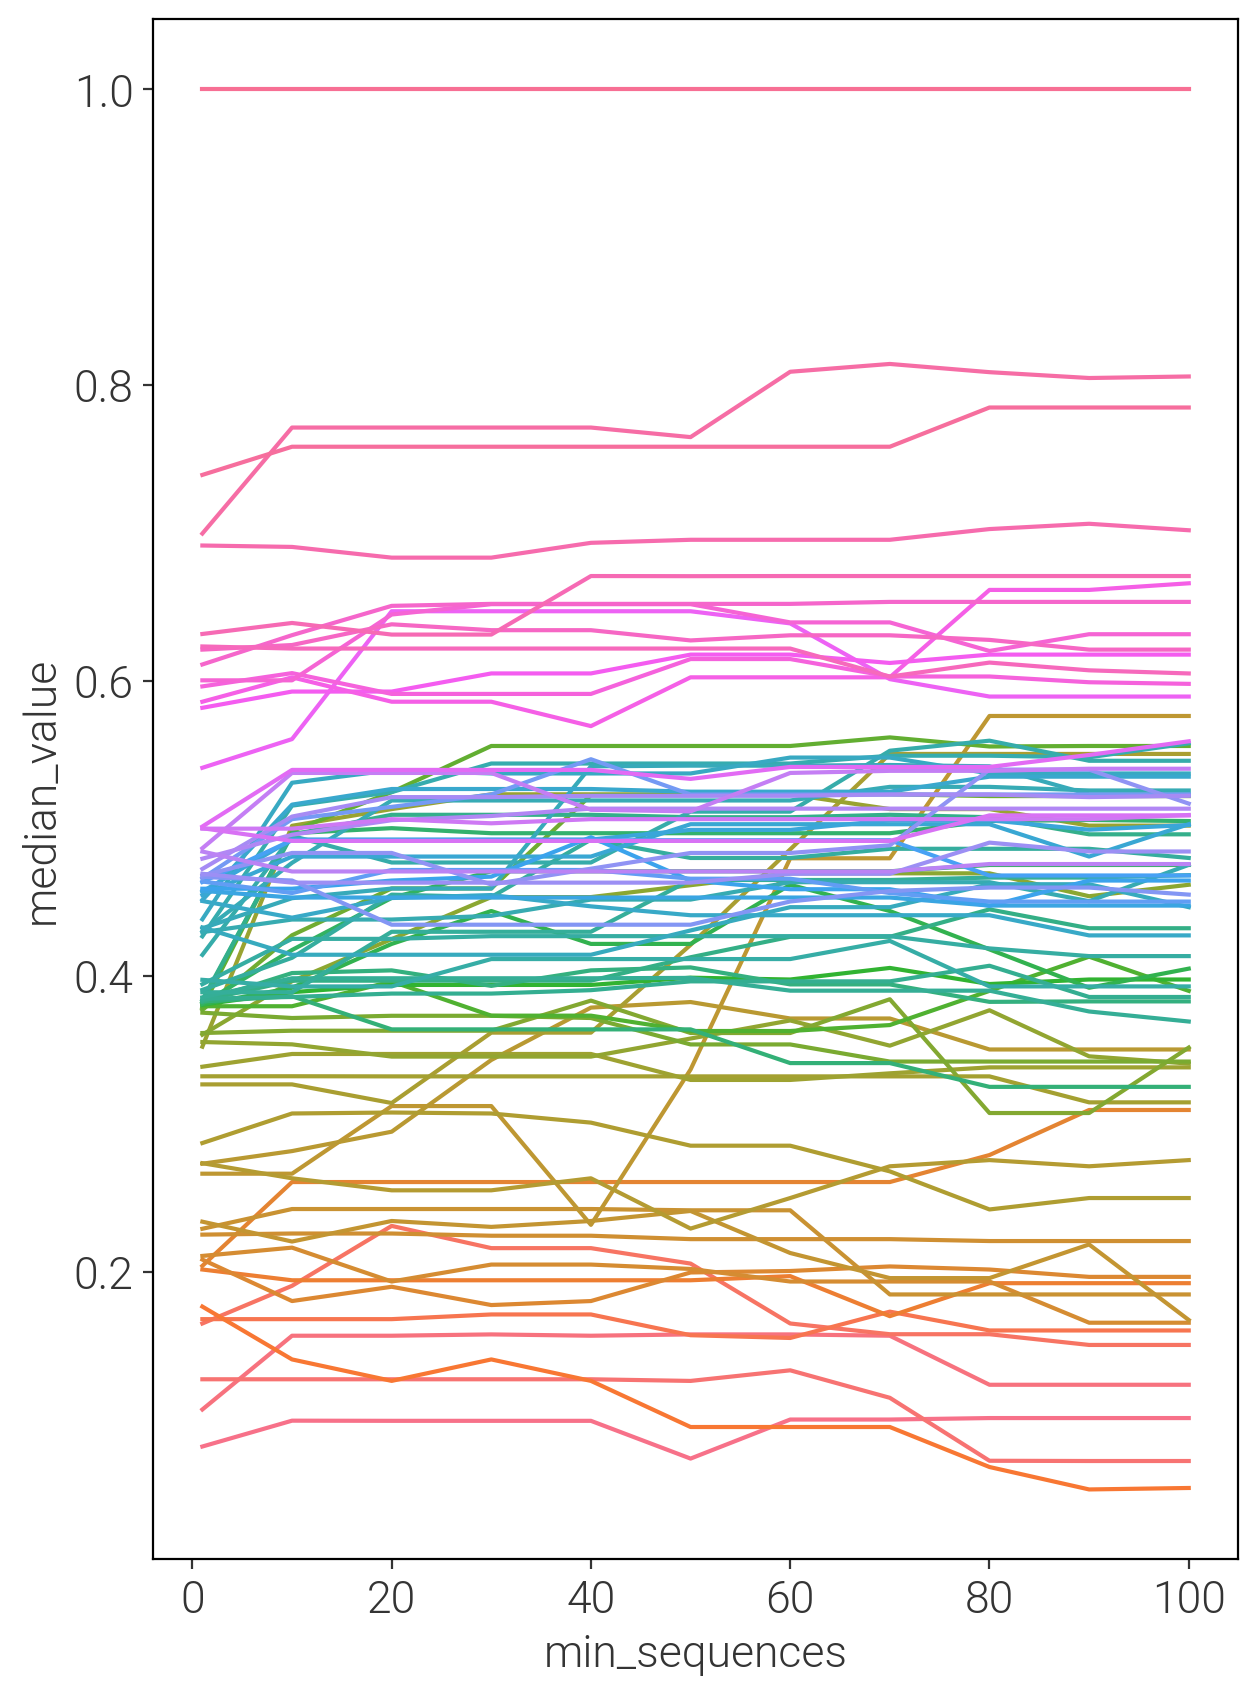

In [17]:
fig, ax = plt.subplots( dpi=200, figsize=(7,10) )
sns.lineplot( x="min_sequences", y="median_value", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100, ax=ax )
ax.legend().remove()

Ranks are moving around a bit, but this probably isn't as big of an effect as it looks. If we compare the correlation between median values from one threshold to the next, we see that median values correlate with R values greater than 93%. We choose 30 because it inidicates the greatest increase in stability of median values.

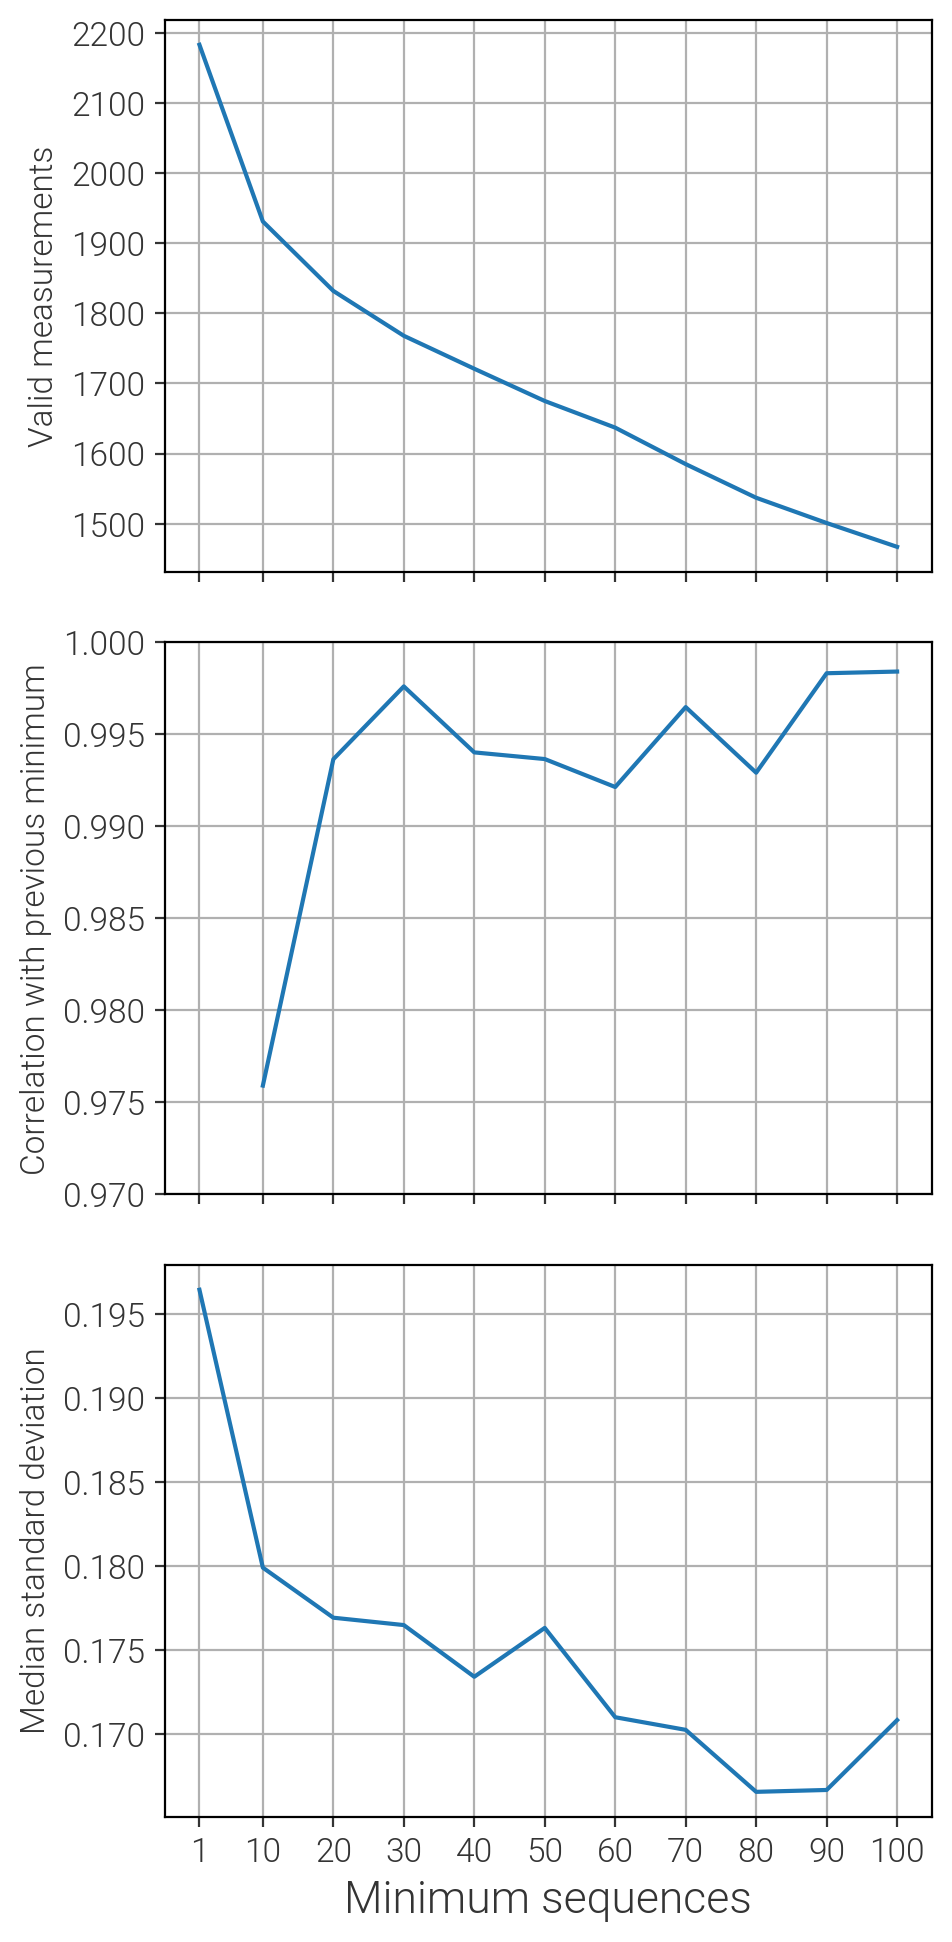

In [18]:
fig, ax = plt.subplots( dpi=200, figsize=(5,10), nrows=3, sharex=True )
count_plot = counts.groupby( "min_sequences")["nonnull_months"].agg("sum")
ax[0].plot( count_plot.index, count_plot )
ax[0].set_ylabel( "Valid measurements", fontsize=12 )
ax[0].tick_params( labelsize=12 )
ax[0].grid()

corr_plot = pd.Series( np.diagonal( medians_corr, 1 ), index=medians_corr.columns[1:] )
ax[1].plot( corr_plot.index, corr_plot )
ax[1].set_ylabel( "Correlation with previous minimum", fontsize=12 )
ax[1].tick_params( labelsize=12 )
ax[1].grid()
ax[1].set_ylim( 0.97, 1 )

var_plot = variance.median()
ax[2].plot( var_plot.index, var_plot )
ax[2].set_ylabel( "Median standard deviation", fontsize=12 )
ax[2].tick_params( labelsize=12 )
#ax[2].set_ylim( 0.025, 0.04 )
ax[2].grid()

ax[2].set_xlabel( "Minimum sequences" )
ax[2].set_xticks( test_values )

plt.tight_layout()
plt.savefig( "../analyses/figureSX_phylosor-minimums.pdf" )
plt.show()
